# Problem



GitHub Repo: https://github.com/mikerhoads/unsupervised-learning-project

In [17]:
import string,re
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import Ridge

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
pd.set_option("display.max_rows", 500)



In [2]:
#https://insideairbnb.com/get-the-data/
listings = pd.read_csv("files/input/listings.csv")
listings.head()



,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,36121,https://www.airbnb.com/rooms/36121,20250301213336,2025-03-03,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,https://a0.muscache.com/pictures/8776354/35b32...,62165,...,5.00,5.00,5.00,NaN,f,1,0,1,0,0.05
1,36647,https://www.airbnb.com/rooms/36647,20250301213336,2025-03-03,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",https://a0.muscache.com/pictures/miso/Hosting-...,157798,...,4.90,4.38,4.71,NaN,f,1,0,1,0,0.58
2,38663,https://www.airbnb.com/rooms/38663,20250301213336,2025-03-02,city scrape,Luxury Brownstone in Boerum Hill,"Beautiful, large home in great hipster neighbo...","diverse, lively, hip, cool: loaded with restau...",https://a0.muscache.com/pictures/miso/Hosting-...,165789,...,4.88,4.86,4.62,OSE-STRREG-0001784,f,1,0,1,0,0.28
3,38833,https://www.airbnb.com/rooms/38833,20250301213336,2025-03-03,city scrape,Spectacular West Harlem Garden Apt,This is a very large and unique space. An inc...,West Harlem is now packed with great restauran...,https://a0.muscache.com/pictures/7554f9e5-4ab0...,166532,...,4.96,4.79,4.82,OSE-STRREG-0000476,f,1,1,0,0,1.36
4,39282,https://www.airbnb.com/rooms/39282,20250301213336,2025-03-02,city scrape,“Work-from-home” from OUR home.,*Monthly Discount will automatically apply <br...,THE NEIGHBORHOOD:<br />Our apartment is locate...,https://a0.muscache.com/pictures/ef8f43ad-d967...,168525,...,4.88,4.85,4.78,OSE-STRREG-0001150,f,2,0,2,0,1.54


In [3]:
reviews = pd.read_csv("files/input/reviews.csv")
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r<br/>Nous avons ...
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...


In [4]:


# Read and basic cleanup
reviews = pd.read_csv("files/input/reviews.csv")
reviews = reviews[~reviews["comments"].isna()]

# Filter out listings with <= 5 reviews
reviews["review_counts"] = reviews["listing_id"].map(
    reviews["listing_id"].value_counts()
)
reviews = reviews[reviews["review_counts"] > 5]

# Clean comments column
def clean_text(text):
    text = re.sub(r"<.*?>", "", text)              # Remove HTML tags
    text = re.sub(r"[^a-zA-Z\s]", "", text)        # Keep only letters and spaces
    text = re.sub(r"\s+", " ", text)               # Collapse multiple spaces
    return text.strip().lower()

reviews["comments"] = reviews["comments"].apply(clean_text)

# Filter out very short comments
reviews["word_count"] = reviews["comments"].apply(lambda x: len(x.split()))
reviews = reviews[reviews["word_count"] > 5]


"""
#This will be commented out because it takes 30 mins to run. I"ve saved a version of it at reviews_cleaned so we can pick up from after the language filter runs

#remove non-English reviews
def check_language(s):
    try:
        return detect(s)
    except:
        return "error"
reviews["language"] = reviews["comments"].apply(lambda x: check_language(x))
reviews = reviews[reviews["language"] == "en"]
reviews = reviews[["listing_id", "id", "date", "reviewer_id", "comments", "word_count"]]
reviews.to_csv("files/input/reviews_cleaned.csv", index=False, quoting=1)
"""



'\n#This will be commented out because it takes 30 mins to run. I"ve saved a version of it at reviews_cleaned so we can pick up from after the language filter runs\n\n#remove non-English reviews\ndef check_language(s):\n    try:\n        return detect(s)\n    except:\n        return "error"\nreviews["language"] = reviews["comments"].apply(lambda x: check_language(x))\nreviews = reviews[reviews["language"] == "en"]\nreviews = reviews[["listing_id", "id", "date", "reviewer_id", "comments", "word_count"]]\nreviews.to_csv("files/input/reviews_cleaned.csv", index=False, quoting=1)\n'

In [5]:
rc = pd.read_csv("files/input/reviews_cleaned.csv")

#REMOVE STOP WORDS
rc["comments"] = rc["comments"].apply(
    lambda x: " ".join([word.lower() for word in x.split() if word.lower() not in STOPWORDS])
)

#Recalculate word count after cleanups
rc["word_count"] = rc["comments"].apply(lambda x: len(x.split()))
rc = rc[rc["word_count"] > 5]

#Refilter after removals
# Filter out listings with <= 5 reviews
rc["review_counts"] = rc["listing_id"].map(
    rc["listing_id"].value_counts()
)
rc = rc[rc["review_counts"] > 5]

listings.isna().sum()





id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
source                                              0
name                                                2
description                                       993
neighborhood_overview                           17210
picture_url                                         1
host_id                                             0
host_url                                            0
host_name                                          38
host_since                                         38
host_location                                    7687
host_about                                      15979
host_response_time                              16148
host_response_rate                              16148
host_acceptance_rate                            14694
host_is_superhost           

In [6]:


#Remove listings without a price
listings = listings[~listings["price"].isna()]

#combine all reviews into a single column per each listing id so we can merge and recalc a new review_count since we removed some
grouped_reviews = (
    rc.groupby("listing_id")["comments"]
    .agg([
        ("reviews_text", lambda x: " ".join(x.dropna())),
        ("review_count", "count")
    ])
    .reset_index()
)

#merge with the listings for the final complete listings dataframe
lf = listings.merge(grouped_reviews, left_on="id", right_on="listing_id", how="inner")
keep_columns = ["id", "name", "description", "host_since",  "host_is_superhost", "host_listings_count", "host_identity_verified", "neighbourhood_cleansed", "neighbourhood_group_cleansed", "latitude", "longitude", "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "amenities", "price", "minimum_nights", "maximum_nights", "minimum_minimum_nights", "availability_30", "availability_60", "availability_90", "availability_365", "number_of_reviews_ltm", "number_of_reviews_l30d", "availability_eoy", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "instant_bookable", "first_review", "review_count", "reviews_text"]
lf = lf[keep_columns]

text_predictors = ["name", "description", "reviews_text"]

#Convert price to float
lf["price"] = lf.price.apply(lambda x: float(x.replace("$", "").replace(",","")))

#Fill blanks
lf["description"] = lf["description"].fillna("")
lf["host_listings_count"] = lf["host_listings_count"].fillna(0)
lf["bathrooms"] = lf["bathrooms"].fillna(0)
lf["bedrooms"] = lf["bedrooms"].fillna(0)
lf["beds"] = lf["beds"].fillna(0)
lf["host_is_superhost"] = lf["host_is_superhost"].fillna("f")
lf["host_identity_verified"] = lf["host_identity_verified"].fillna("f")

#convert dates and fill blanks
lf["host_since"] = pd.to_datetime(lf["host_since"])
lf["host_since"] = lf["host_since"].fillna(lf["host_since"].median())

lf["first_review"] = pd.to_datetime(lf["first_review"])

#convert boolean string columns to 1 or 0
lf["host_is_superhost"] = lf["host_is_superhost"].apply(lambda x: 1 if x=="t" else 0)
lf["host_identity_verified"] = lf["host_identity_verified"].apply(lambda x: 1 if x=="t" else 0)
lf["instant_bookable"] = lf["instant_bookable"].apply(lambda x: 1 if x=="t" else 0)


#lf.head(2).to_csv("files/input/listings_preview.csv", index=False, quoting=1)


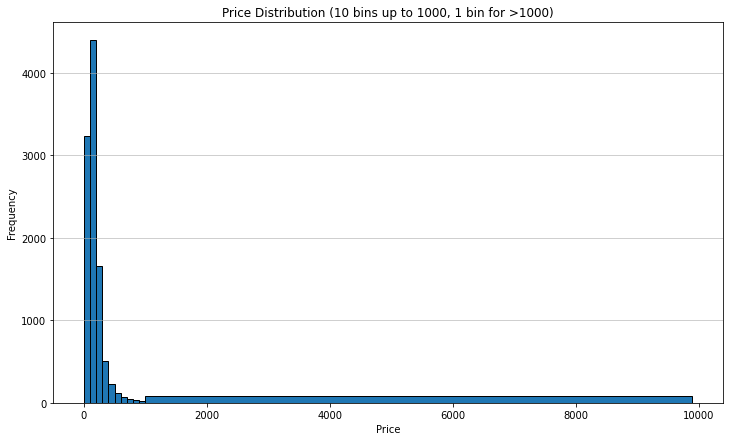

In [7]:

# Define 10 bins from 0 to 1000
bins = np.linspace(0, 1000, 11).tolist()  # 10 equal bins (11 edges)
# Add one extra bin edge for >1000
bins.append(lf["price"].max())

plt.figure(figsize=(12, 7))
plt.hist(lf["price"], bins=bins, edgecolor="black")
plt.title("Price Distribution (10 bins up to 1000, 1 bin for >1000)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

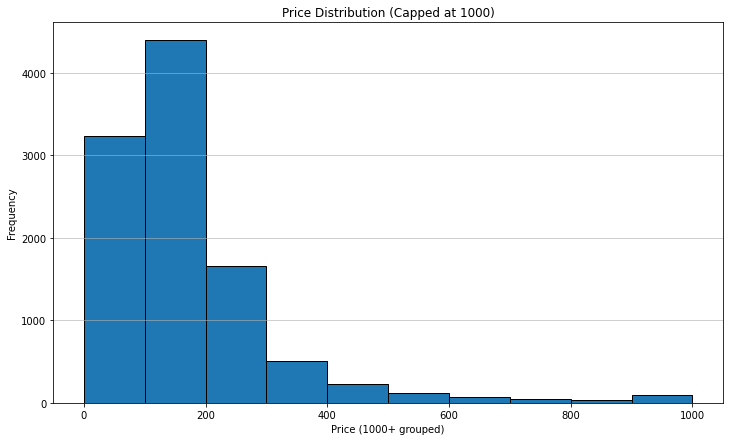

In [8]:
prices = lf["price"]
capped_prices = np.where(prices > 1000, 1000, prices)

# Now use normal bins between 0 and 1000
bins = np.linspace(0, 1000, 11)  # 10 equal bins

plt.figure(figsize=(12, 7))
plt.hist(capped_prices, bins=bins, edgecolor="black")
plt.title("Price Distribution (Capped at 1000)")
plt.xlabel("Price (1000+ grouped)")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

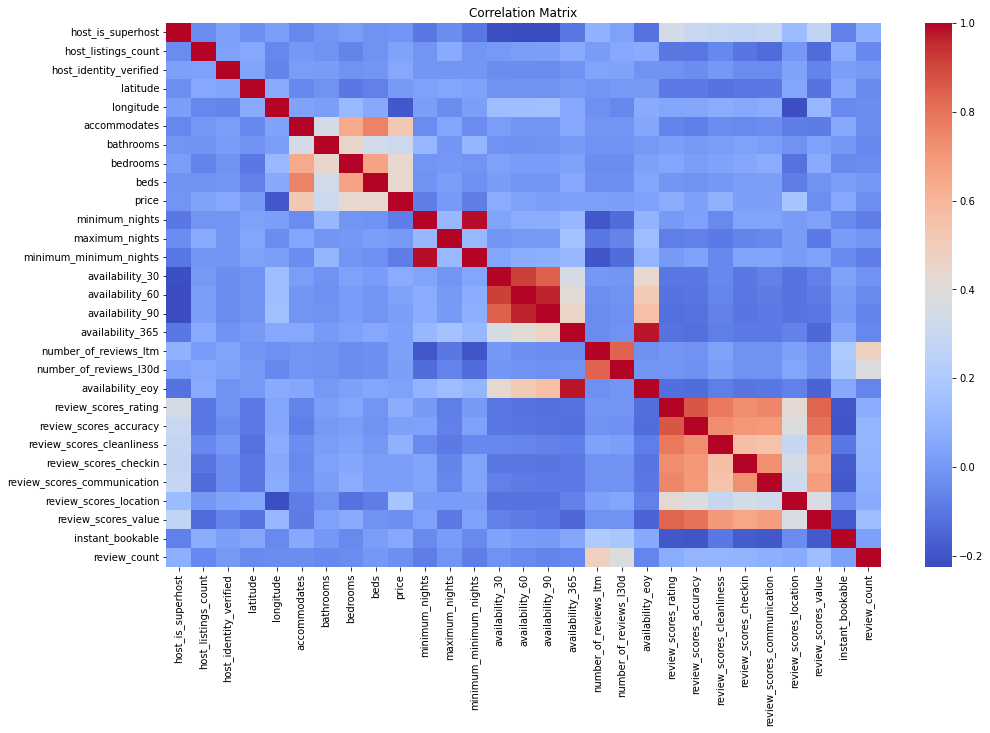

In [9]:

lf = lf[lf["price"] <= 1000]

numeric_predictors = lf.select_dtypes(include=['number']).columns.tolist()
numeric_predictors.remove('id')

corr_matrix = lf[numeric_predictors].corr(method='pearson')

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

numeric_predictors.remove('price')


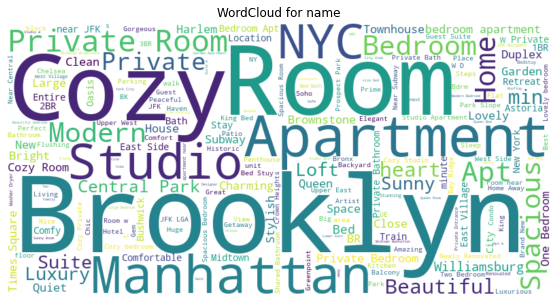

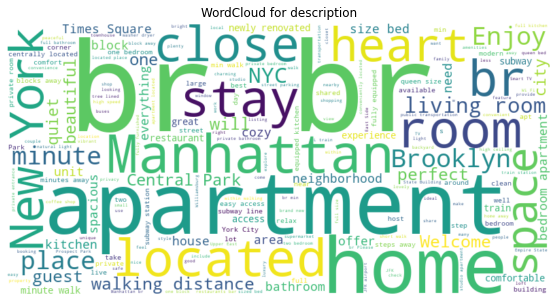

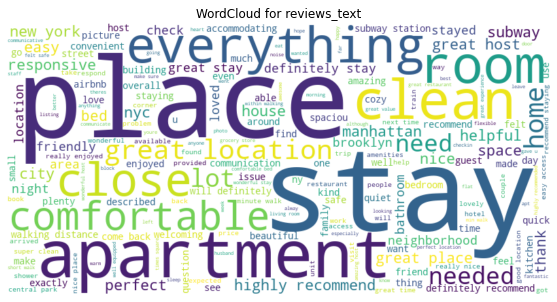

In [ ]:
for col in text_predictors:
    text = " ".join(lf[col])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for {col}")
    plt.show()

In [18]:




# 1) Split into features and target
X = lf[numeric_predictors]
y = lf['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2) Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 3) PCA to explain 95% of variance
pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of PCA components retained: {pca.n_components_}")
print(f"PCA-transformed training set shape: {X_train_pca.shape}")

# 4) Train Ridge regressor model
model = Ridge(alpha=1.0, random_state=42)
model.fit(X_train_pca, y_train)

# 5) Scale & project the test set
X_test_scaled = scaler.transform(X_test)
X_test_pca    = pca.transform(X_test_scaled)
print("Test PCA shape:", X_test_pca.shape)

# 6) Predict and evaluate
y_pred = model.predict(X_test_pca)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Test MSE:  {mse:.3f}")
print(f"Test RMSE: {rmse:.3f}")

print("----Comparing to ---")
y_mean = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_mean))
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"The model improves RMSE by {baseline_rmse - rmse:.2f} dollars")
nrmse = rmse / y_test.mean()
print(f"Normalized RMSE: {nrmse:.2%} of average price")
print("Test R²:", r2_score(y_test, y_pred).round(3))


Original number of features: 28
Number of PCA components retained: 24
PCA-transformed training set shape: (8248, 24)
Test PCA shape: (2062, 24)
Test MSE:  9053.860
Test RMSE: 95.152
----Comparing to ---
Baseline RMSE: 129.21
The model improves RMSE by 34.06 dollars
Normalized RMSE: 55.41% of average price
Test R²: 0.457


### Problem



# References
- Data: https://insideairbnb.com/get-the-data/
- Sklearn: https://scikit-learn.org/0.21/documentation.html
- Langdetect: https://pypi.org/project/langdetect/
- Seaborn: https://seaborn.pydata.org/
